# Transfering Xenium 5K IDB and RA from server to gbucket

```bash
gcloud auth login

gsutil -o GSUtil:parallel_composite_upload_threshold=2G -o GSUtil:parallel_thread_count=32 -o GSUtil:parallel_process_count=16 -m cp -r "gs://chumm_bucket/output-XETG00123__0033589__TIS08736-001-011__20241004__003818.zip" "/home/jupyter/Xen_5K_CellCell_Comm/TIS08736-001-011.zip"

gsutil -o GSUtil:parallel_composite_upload_threshold=2G -o GSUtil:parallel_thread_count=32 -o GSUtil:parallel_process_count=16 -m cp -r "gs://chumm_bucket/output-XETG00195__0030473__TMA04854-02-001__20240816__000559.zip" "/home/jupyter/Xen_5K_CellCell_Comm/TMA04854-02-001.zip"
```

# Creating and starting venv

```bash
source $HOME/xen_5k_ibd_ra/xen5k_env.sh
```

# Setting up

In [3]:
from xen5k_utils import *

hdir = '/home/workspace/'
srldir = hdir + 'xen_5k_ibd_ra/xen5k_objects/'
raw_adatas = load(srldir + 'raw_adatas.joblib')
adatas = load(srldir + 'processed_adatas.joblib')

with open(srldir + 'sdatas.pkl', 'rb') as f:
    sdatas = dill.load(f)

# Ingesting spaceranger outputs and generating adatas

In [ ]:
samples = {
    'ibd': hdir + 'xen_5k_ibd_ra/TMA04854-02-001.zip',
    'ra': hdir + 'xen_5k_ibd_ra/TIS08736-001-011.zip'
}

sdatas = {
    name: read_from_zip(path)
    for name, path in samples.items()
}

with open(srldir + 'sdatas.pkl', 'wb') as f:
    dill.dump(sdatas, f)

raw_adatas = {
    name: sdata.tables['table'].copy()
    for name, sdata in sdatas.items()
}

dump(adatas, srldir + 'raw_adatas.joblib', compress=3)

# Processing adatas

In [ ]:
adatas = {
    name: process_adata(adata.copy())
    for name, adata in raw_adatas.items()
}

dump(adatas, srldir + 'processed_adatas.joblib', compress=3)

# QC Metrics

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6), gridspec_kw={'hspace':0.4, 'wspace':0.4})
plt.subplots_adjust(left=0.15)

for i, (name, adata) in enumerate(adatas.items()):
    ratio = adata.obs["nucleus_area"] / adata.obs["cell_area"]
    metrics = {
        'transcripts': {
            'median': adata.obs["total_counts"].median(),
            'mean': adata.obs["total_counts"].mean()
        },
        'genes': {
            'median': adata.obs["n_genes_by_counts"].median(),
            'mean': adata.obs["n_genes_by_counts"].mean()
        },
        'area': {
            'median': adata.obs["cell_area"].median(),
            'mean': adata.obs["cell_area"].mean()
        },
        'ratio': {
            'median': ratio.median(),
            'mean': ratio.mean()
        }
    }
    
    fig.text(0.075, 0.75 - i*0.5, name, rotation=90, va='center', fontsize=12, fontweight='bold')

    axs[i, 0].set_title("Total transcripts per cell")
    transcript_text = f'mean: {metrics["transcripts"]["mean"]:.2f}\nmedian: {metrics["transcripts"]["median"]:.2f}'
    axs[i, 0].text(0.05, 0.95, transcript_text,
                   transform=axs[i, 0].transAxes,
                   horizontalalignment='left',
                   verticalalignment='top')
    sns.histplot(
        adata.obs["total_counts"],
        kde=False,
        ax=axs[i, 0],
    )

    axs[i, 1].set_title("Unique transcripts per cell")
    gene_text = f'mean: {metrics["genes"]["mean"]:.2f}\nmedian: {metrics["genes"]["median"]:.0f}'
    axs[i, 1].text(0.95, 0.95, gene_text,
                   transform=axs[i, 1].transAxes,
                   horizontalalignment='right',
                   verticalalignment='top')
    sns.histplot(
        adata.obs["n_genes_by_counts"],
        kde=False,
        ax=axs[i, 1],
    )

    axs[i, 2].set_title("Area of segmented cells")
    area_text = f'mean: {metrics["area"]["mean"]:.2f}\nmedian: {metrics["area"]["median"]:.2f}'
    axs[i, 2].text(0.95, 0.95, area_text,
                   transform=axs[i, 2].transAxes,
                   horizontalalignment='right',
                   verticalalignment='top')
    sns.histplot(
        adata.obs["cell_area"],
        kde=False,
        ax=axs[i, 2],
    )

    axs[i, 3].set_title("Nucleus ratio")
    ratio_text = f'mean: {metrics["ratio"]["mean"]:.2f}\nmedian: {metrics["ratio"]["median"]:.2f}'
    axs[i, 3].text(0.95, 0.95, ratio_text,
                   transform=axs[i, 3].transAxes,
                   horizontalalignment='right',
                   verticalalignment='top')
    sns.histplot(
        adata.obs["nucleus_area"] / adata.obs["cell_area"],
        kde=False,
        ax=axs[i, 3],
    )

# Optimal Clustering

In [ ]:
range = np.round(np.arange(0.1, 1.1, 0.1), 1)

for _, adata in adatas.items():
    for res in range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )

dump(adatas, srldir + 'processed_adatas.joblib', compress=3)

In [ ]:
for _, adata in adatas.items():
    fig = clustree(
        adata,
        [f"leiden_{str(res).replace('.', '_')}" for res in range],
        score_clustering="calinski_harabasz",
        score_basis="pca"
    )

    fig.set_size_inches(15, 20)
    fig.set_dpi(100)

# UMAPs

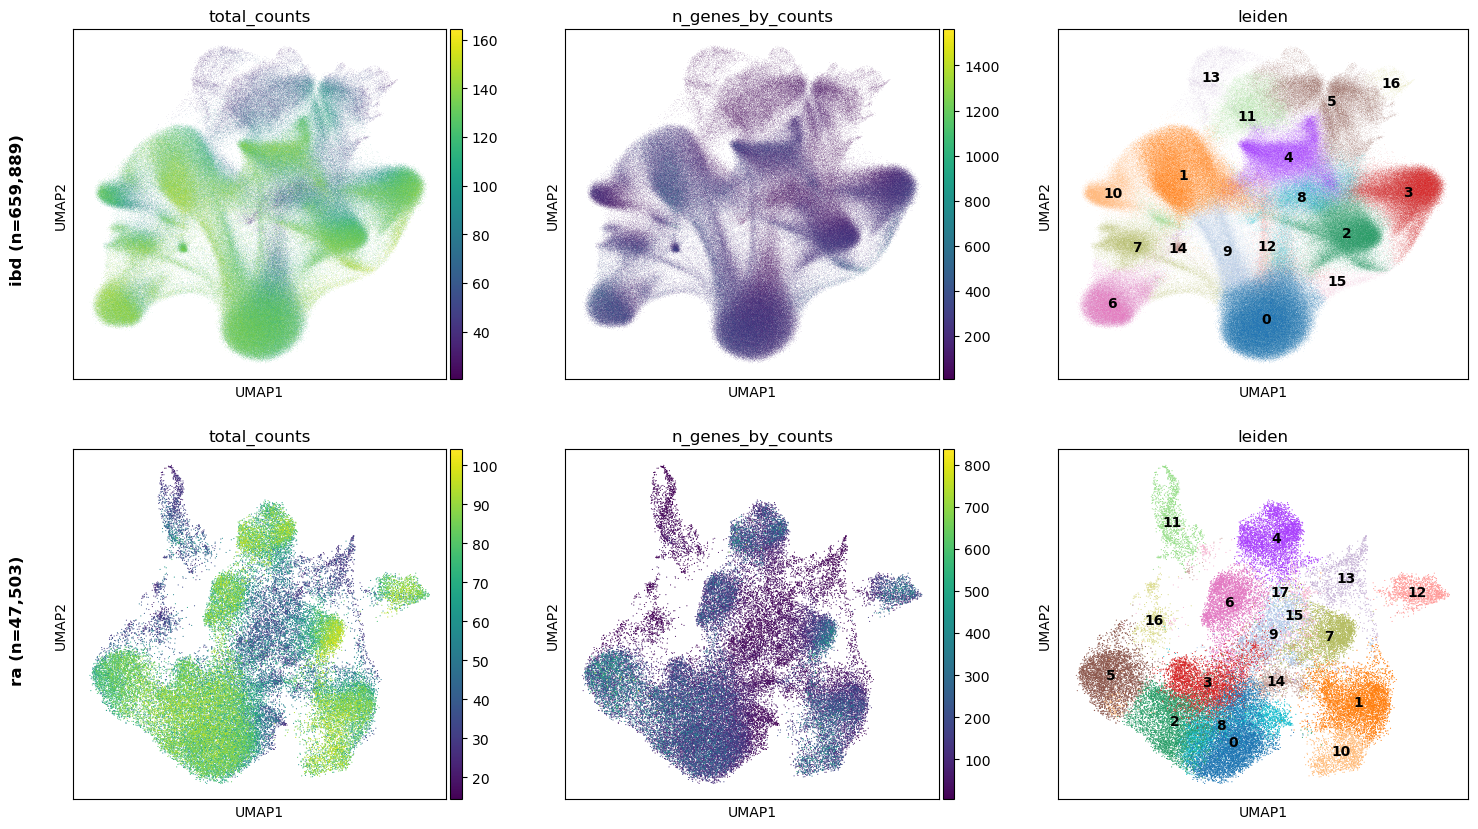

In [70]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

colors = ["total_counts", "n_genes_by_counts", "leiden"]

for i, (name, adata) in enumerate(adatas.items()):
    fig.text(0.09, 0.70 - (i * 0.41), f"{name} (n={len(adata.obs):,})", rotation=90, va='center', fontsize=12, fontweight='bold', verticalalignment='center')
    
    for j, color in enumerate(colors):
        sc.pl.umap(
            adata,
            color=color,
            legend_loc='on data',
            ax=axs[i, j],
            show=False
        )

plt.show()

# Spatial Cluster Map

/home/workspace/xen_5k_ibd_ra/xen5k_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/workspace/xen_5k_ibd_ra/xen5k_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


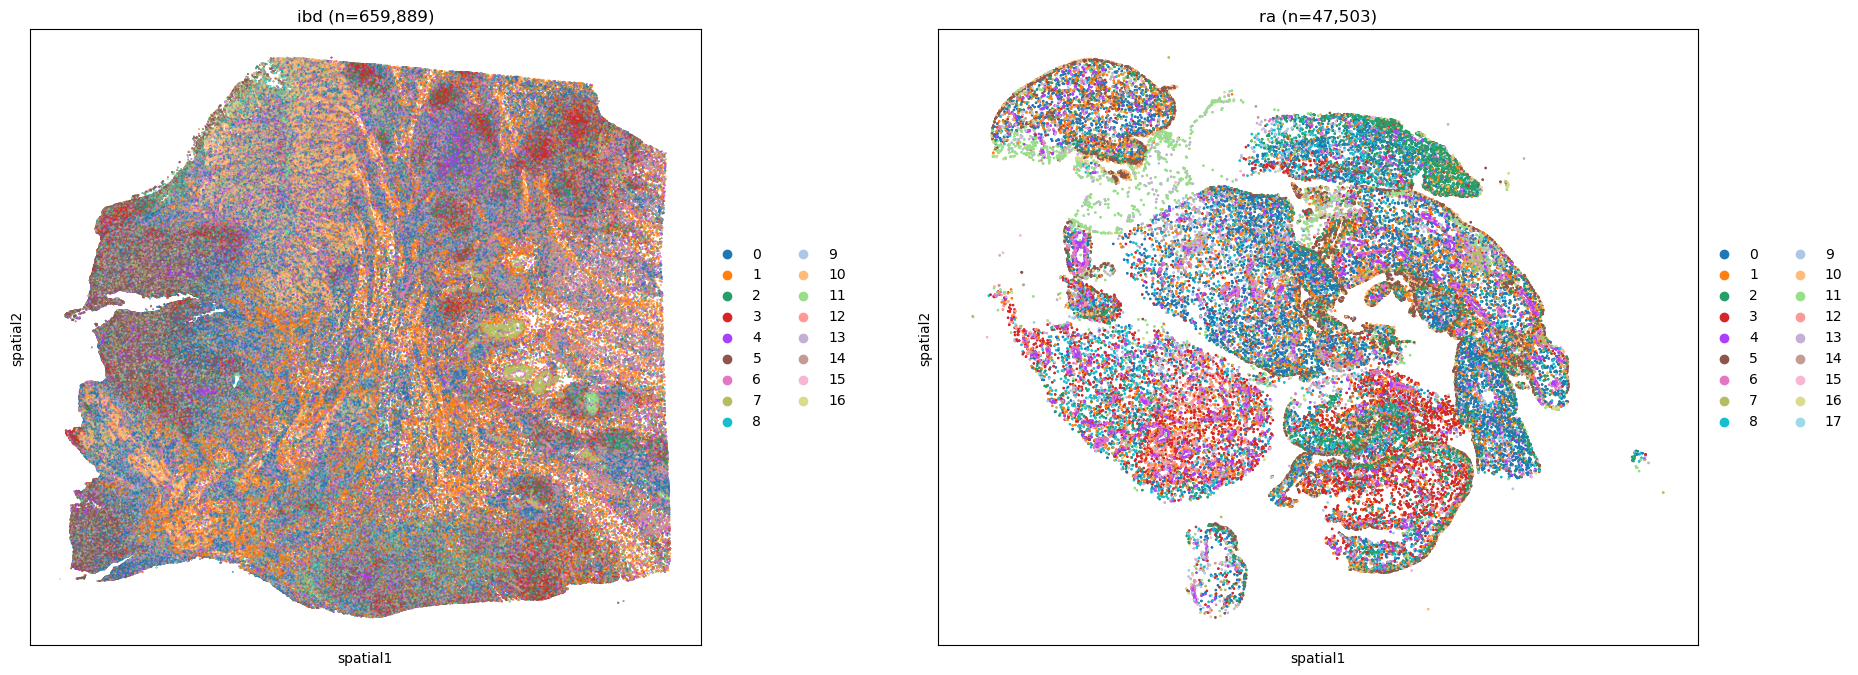

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8), gridspec_kw={'wspace':0.05})

for i, (name, adata) in enumerate(adatas.items()):
    sq.pl.spatial_scatter(
        adata,
        library_id="spatial",
        shape=None,
        color="leiden",
        ax=axs[i]
    )
    
    axs[i].set_title(f"{name} (n={len(adata.obs):,})")

plt.show()

# Centrality Scores

In [ ]:
[sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5)) for adata in adatas.values()]

# Compute co-occurrence probability

In [ ]:
for name, sdata in sdatas.items():
    sdata.tables["subsample"] = sc.pp.subsample(adatas[name], fraction=0.8, copy=True)
    sq.gr.co_occurrence(
        sdata.tables["subsample"],
        cluster_key="leiden",
        n_jobs=60
    )

with open(srldir + 'sdatas.pkl', 'wb') as f:
    dill.dump(sdatas, f)

In [ ]:
fig, ax = plt.subplots()

for _, sdata in sdatas.items():
    sq.pl.co_occurrence(
        sdata.tables["subsample"],
        cluster_key="leiden",
        clusters="11",
    )
    
    sq.pl.spatial_scatter(
        sdata.tables["subsample"],
        color="leiden",
        shape=None,
        size=2,
    )

# Neighbors enrichment analysis

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(13, 12), gridspec_kw={'wspace':0.2})

# help(fig.text)
help(sq.pl.nhood_enrichment)

/home/workspace/xen_5k_ibd_ra/xen5k_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/workspace/xen_5k_ibd_ra/xen5k_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


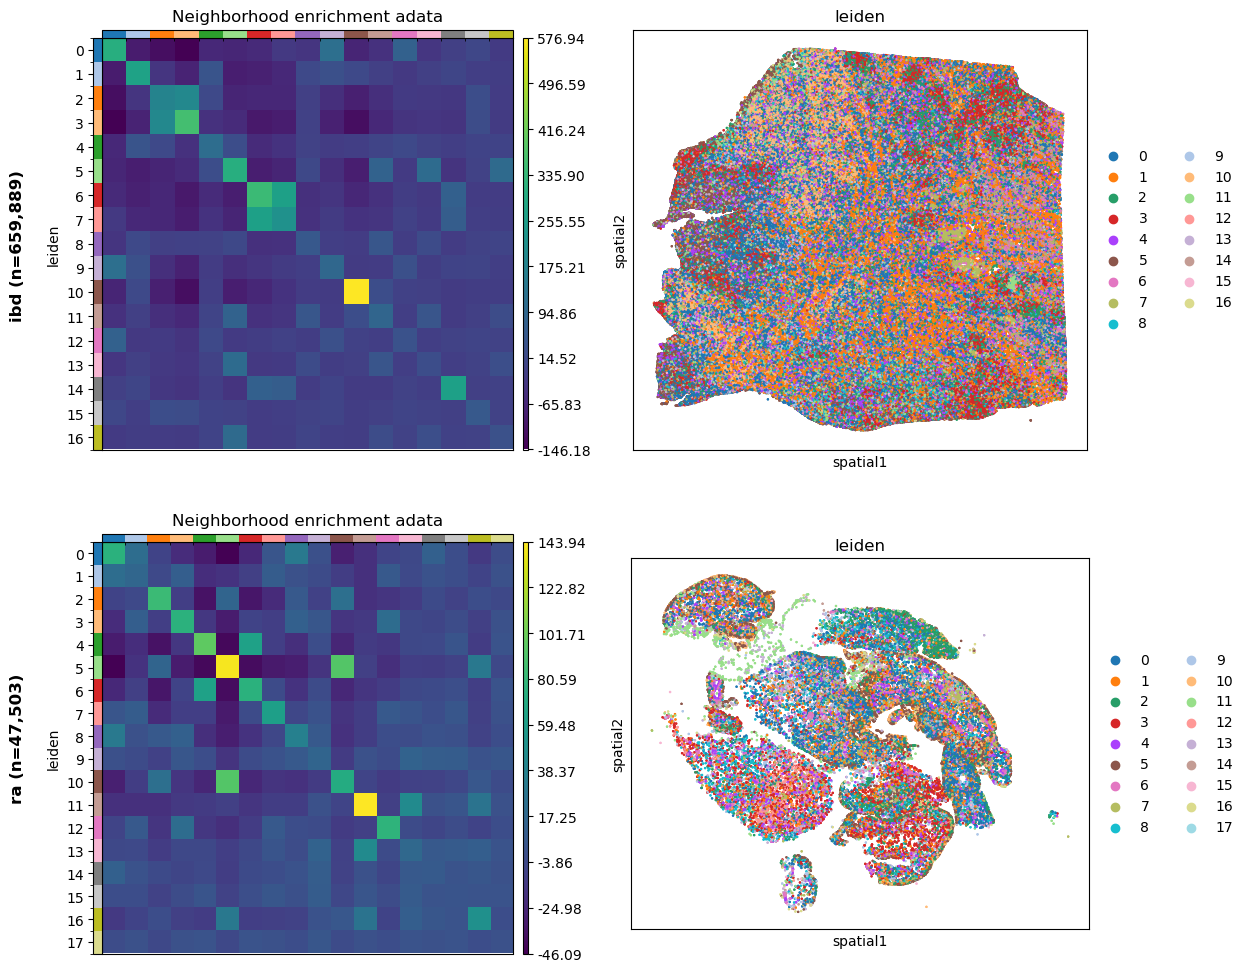

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12), gridspec_kw={'wspace':0.2})

for i, (name, adata) in enumerate(adatas.items()):
    fig.text(0.07, 0.70 - (i * 0.41), f"{name} (n={len(adata.obs):,})", rotation=90, va='center', fontsize=12, fontweight='bold', verticalalignment='center')
    
    sq.pl.nhood_enrichment(
        adata,
        cluster_key="leiden",
        figsize=(8, 8),
        title="Neighborhood enrichment adata",
        ax=ax[i, 0],
        palette=sns.color_palette("tab20", n_colors=20)
    )
    
    sq.pl.spatial_scatter(sdatas[name].tables["subsample"], color="leiden", shape=None, size=2, ax=ax[i, 1])

# Compute Moran’s I score (TNF, IL17A, IL23A, IL6, IL10, IFNg, IFNA_, TGFb_)

In [9]:
for _, sdata in sdatas.items():
    sq.gr.spatial_autocorr(
        sdata.tables["subsample"],
        mode="moran",
        n_perms=100,
        n_jobs=60
    )
    # sdata.tables["subsample"].uns["moranI"].head(10)

with open(srldir + 'sdatas.pkl', 'wb') as f:
    dill.dump(sdatas, f)

  0%|          | 0/100 [00:00<?, ?/s]

KeyboardInterrupt: 

In [ ]:
# For statistical testing
results = bivariate_morans_i_test(sdatas['ibd'].tables["subsample"], "gene1", "gene2", 
                                 n_perms=1000, 
                                 layer="counts", 
                                 seed=42)
print(f"Bivariate Moran's I: {results['statistic']:.4f}")
print(f"P-value: {results['p_value']:.4f}")

In [11]:
IFNA_ = ["IFNA1", "IFNA17", "IFNA2", "IFNA7", "IFNA8"]
TGFB_ = ["TGFB1", "TGFB1I1", "TGFB2", "TGFB3"]

ligands = ["TNF", "IL17A", "IL23A", "IL6", "IL10", "IFNG"] + IFNA_ + TGFB_

{
    gene: gene in adatas['ibd'].var.gene_ids
    for gene in ligands
}

{'TNF': True,
 'IL17A': True,
 'IL23A': True,
 'IL6': True,
 'IL10': True,
 'IFNG': True,
 'IFNA1': True,
 'IFNA17': True,
 'IFNA2': True,
 'IFNA7': True,
 'IFNA8': True,
 'TGFB1': True,
 'TGFB1I1': True,
 'TGFB2': True,
 'TGFB3': True}

## Genes of interest Moran's I spatial heatmap

- Genes of interest showing low Moran's I in spatial heatmap

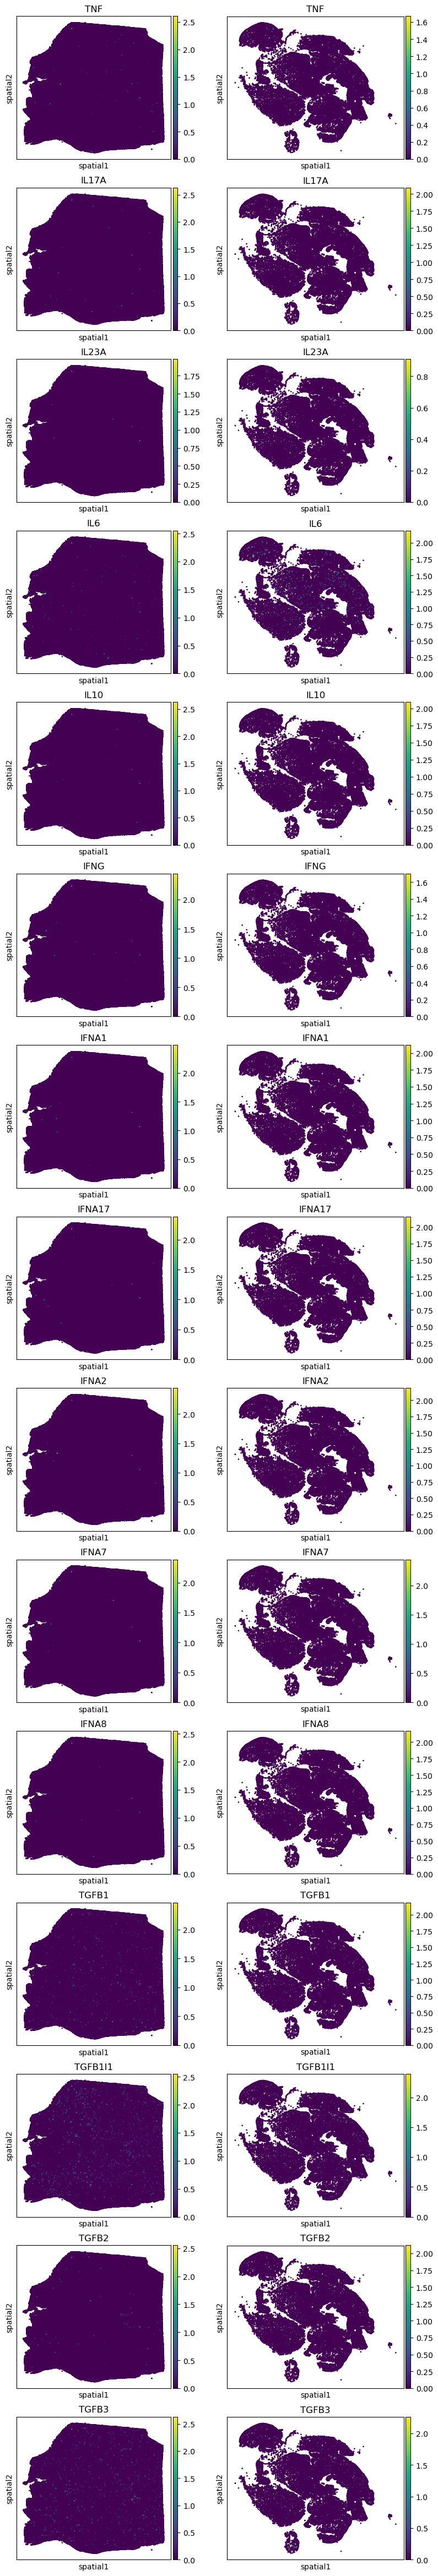

In [5]:
IFNA_ = ["IFNA1", "IFNA17", "IFNA2", "IFNA7", "IFNA8"]
TGFB_ = ["TGFB1", "TGFB1I1", "TGFB2", "TGFB3"]

ligands = ["TNF", "IL17A", "IL23A", "IL6", "IL10", "IFNG"] + IFNA_ + TGFB_

fig, ax = plt.subplots(len(ligands), 2, figsize=(13, 60))

for i, ligand in enumerate(ligands):
    for x, sdata in enumerate(sdatas.values()):
        sq.pl.spatial_scatter(
            sdata.tables["subsample"],
            library_id="spatial",
            color=ligand,
            shape=None,
            size=2,
            img=False,
            ax=ax[i, x]
        )

## Top 10 Moran's I Genes spatial heatmap

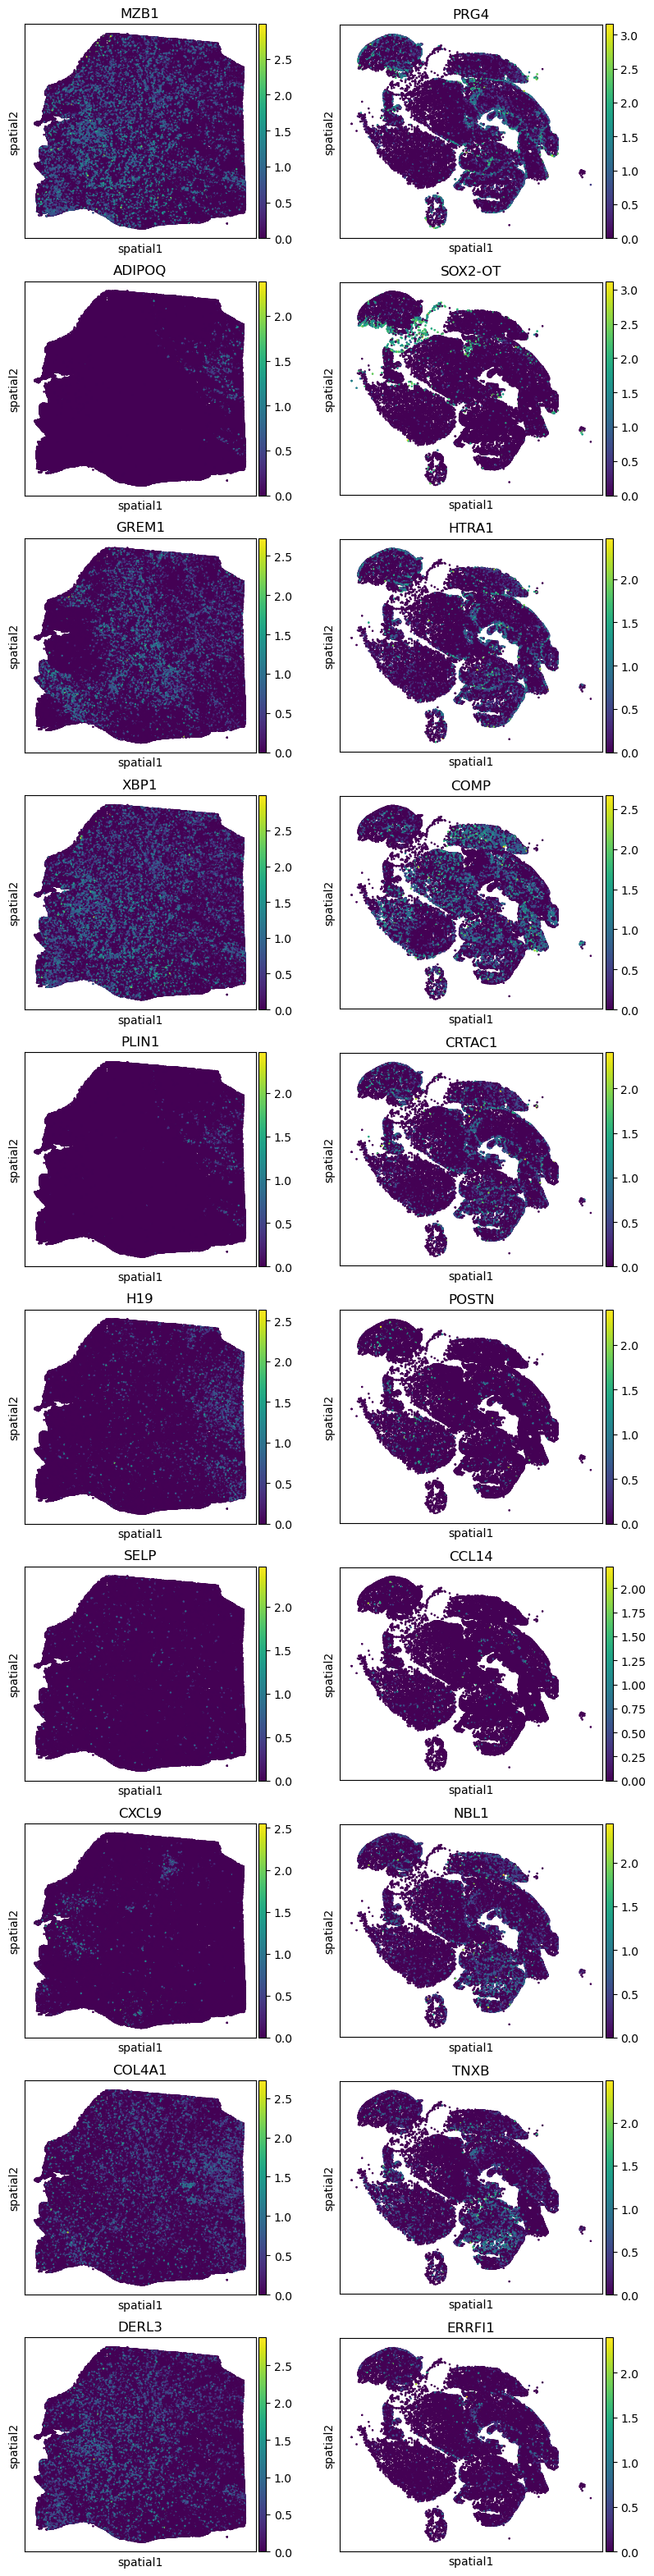

In [131]:
top_moransi = {
    name: list(sdata.tables["subsample"].uns['moranI'].sort_values(by="I", ascending=False).iloc[0:10, 0].index)
    for name, sdata in sdatas.items()
}

fig, ax = plt.subplots(10, 2, figsize=(10, 40))

for i, (name, sdata) in enumerate(sdatas.items()):
    for x, gene in enumerate(top_moransi[name]):
        sq.pl.spatial_scatter(
            sdata.tables["subsample"],
            library_id="spatial",
            color=gene,
            shape=None,
            size=2,
            img=False,
            ax=ax[x, i]
        )

## Genes of Interest Moran's I dotplot

- Genes of interest showing low Moran's I in spatial heatmap

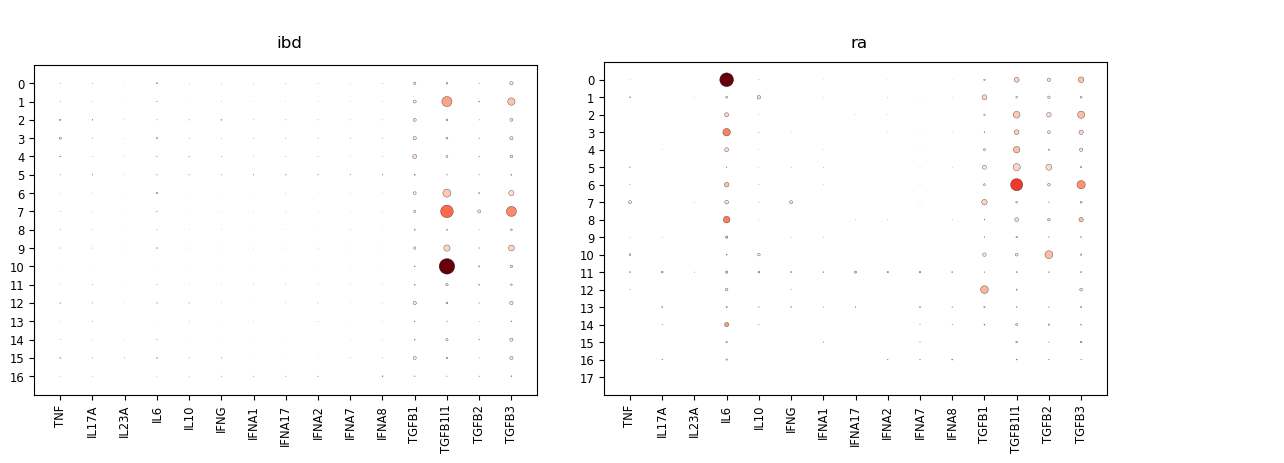

In [138]:
IFNA_ = ["IFNA1", "IFNA17", "IFNA2", "IFNA7", "IFNA8"]
TGFB_ = ["TGFB1", "TGFB1I1", "TGFB2", "TGFB3"]

ligands = ["TNF", "IL17A", "IL23A", "IL6", "IL10", "IFNG"] + IFNA_ + TGFB_

fig, ax = plt.subplots(1, len(sdatas), figsize=(8 * len(sdatas), 5), gridspec_kw={'wspace': -0.15})

for i, (name, sdata) in enumerate(sdatas.items()):
    dp = sc.pl.dotplot(
        sdata.tables["subsample"],
        groupby = 'leiden',
        var_names = ligands,
        show = False,
        ax = ax[i]
    )
    dp['size_legend_ax'].remove()
    dp['color_legend_ax'].remove()
    
    ax[i].set_title(name, y = 0.88, x = 0.38)

In [8]:
from typing import Dict, Union, Optional
import numpy as np
import pandas as pd
from anndata import AnnData
from numpy.random import default_rng
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

def gene_ripley_l(
    adata: AnnData,
    reference_gene: str,
    test_genes: list[str],
    spatial_key: str = 'spatial',
    expression_threshold: float = 0.9,  # quantile threshold
    n_simulations: int = 100,
    max_dist: Optional[float] = None,
    n_steps: int = 50,
    seed: Optional[int] = None,
) -> Dict[str, Union[pd.DataFrame, np.ndarray]]:
    """
    Calculate Ripley's L statistic for spatial correlation between genes.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    reference_gene : str
        Name of reference gene (e.g., CXCL9).
    test_genes : list[str]
        List of genes to test for spatial correlation.
    spatial_key : str
        Key in adata.obsm where spatial coordinates are stored.
    expression_threshold : float
        Quantile threshold for considering high expression.
    n_simulations : int
        Number of simulations for null model.
    max_dist : float, optional
        Maximum distance for analysis. If None, computed from data.
    n_steps : int
        Number of distance steps to evaluate.
    seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    Dict containing L statistics, p-values, and distance bins
    """
    # Get spatial coordinates
    coordinates = adata.obsm[spatial_key]
    
    # Get expression and normalize
    ref_expr = adata[:, reference_gene].X.toarray().flatten()
    ref_high = ref_expr > np.quantile(ref_expr, expression_threshold)
    
    # Prepare support (distance bins)
    hull = ConvexHull(coordinates)
    area = hull.volume
    if max_dist is None:
        max_dist = (area / 2) ** 0.5
    support = np.linspace(0, max_dist, n_steps)
    
    # Initialize results storage
    n_genes = len(test_genes)
    obs_arr = np.empty((n_genes, n_steps))
    pvalues = np.ones((n_genes, n_steps))
    N = coordinates.shape[0]
    
    # Calculate L function for each test gene
    for idx, gene in enumerate(test_genes):
        # Get expression for test gene
        test_expr = adata[:, gene].X.toarray().flatten()
        test_high = test_expr > np.quantile(test_expr, expression_threshold)
        
        # Get coordinates where both genes are highly expressed
        joint_coords = coordinates[ref_high & test_high]
        
        # Calculate L function
        if joint_coords.shape[0] > 1:  # Check if we have enough points
            distances = pdist(joint_coords)
            obs_arr[idx] = _l_function(distances, support, N, area)[1]
    
    # Compute null model and p-values through simulation
    sims = np.empty((n_simulations, n_steps))
    rng = default_rng(seed)
    
    for i in range(n_simulations):
        # Generate random points for null model
        random_mask = rng.random(N) < (ref_high & test_high).mean()
        random_coords = coordinates[random_mask]
        
        if random_coords.shape[0] > 1:
            distances = pdist(random_coords)
            _, l_stat = _l_function(distances, support, N, area)
            sims[i] = l_stat
            
            # Update p-values
            for j in range(n_genes):
                pvalues[j] += (l_stat >= obs_arr[j])
    
    pvalues /= n_simulations + 1
    pvalues = np.minimum(pvalues, 1 - pvalues)
    
    # Format results
    obs_df = pd.DataFrame(
        obs_arr.T,
        columns=test_genes,
        index=support
    )
    obs_df.index.name = 'distance'
    
    sims_df = pd.DataFrame(
        sims.T,
        columns=[f'sim_{i}' for i in range(n_simulations)],
        index=support
    )
    sims_df.index.name = 'distance'
    
    return {
        'L_stat': obs_df,
        'sims_stat': sims_df,
        'pvalues': pvalues,
        'bins': support
    }

def _l_function(distances: np.ndarray, support: np.ndarray, n: int, area: float) -> tuple[np.ndarray, np.ndarray]:
    """Calculate L function from point pattern distances."""
    n_pairs_less_than_d = (distances < support.reshape(-1, 1)).sum(axis=1)
    intensity = n / area
    k_estimate = ((n_pairs_less_than_d * 2) / n) / intensity
    l_estimate = np.sqrt(k_estimate / np.pi)
    return support, l_estimate

In [13]:
results = gene_ripley_l(
    sdatas['ibd'].tables["subsample"],
    reference_gene='CXCL9',
    test_genes=["TGFB1", "TGFB1I1", "TGFB2", "TGFB3"],
    expression_threshold=0.9
)

sdatas['ibd'].tables["subsample"].uns['gene_ripley_L'] = results.copy()

sq.pl.ripley(sdatas['ibd'].tables["subsample"], cluster_key="leiden", mode="L")

dict_keys(['L_stat', 'sims_stat', 'pvalues', 'bins'])

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_ripley_results(results, top_n=20, significance_threshold=0.05):
    """
    Create comprehensive visualizations of Ripley's L analysis results.
    
    Parameters
    ----------
    results : dict
        Output from gene_ripley_l function
    top_n : int
        Number of top genes to show in summary plots
    significance_threshold : float
        P-value threshold for significance
    """
    L_stat = results['L_stat']
    sims_stat = results['sims_stat']
    pvalues = results['pvalues']
    bins = results['bins']
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Max L-statistic plot (overall strength of correlation)
    ax1 = plt.subplot(121)
    max_L = L_stat.max()
    max_L.sort_values(ascending=False)[:top_n].plot(kind='bar')
    plt.title('Maximum L-statistic by Gene\n(higher = stronger spatial correlation)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Max L-statistic')
    
    # 2. Distance-varying patterns
    ax2 = plt.subplot(122)
    # Plot confidence envelope from simulations
    sim_mean = sims_stat.mean(axis=1)
    sim_std = sims_stat.std(axis=1)
    plt.fill_between(bins, 
                     sim_mean - 2*sim_std,
                     sim_mean + 2*sim_std,
                     alpha=0.2, color='gray', label='95% CI under CSR')
    
    # Plot top 5 genes
    top_5_genes = max_L.nlargest(5).index
    for gene in top_5_genes:
        plt.plot(bins, L_stat[gene], label=gene)
    
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Distance')
    plt.ylabel('L(r)')
    plt.title('L-function by Distance\nfor Top 5 Genes')
    plt.legend()
    
    plt.tight_layout()
    
    # Create a summary dataframe for easy ranking
    summary = pd.DataFrame({
        'max_L': max_L,
        'min_pvalue': [min(p) for p in pvalues],
        'significant_scales': [(p < significance_threshold).sum() for p in pvalues]
    })
    
    return summary.sort_values('max_L', ascending=False)

Top spatially correlated genes:
            max_L  min_pvalue  significant_scales
TGFB3    9.371011         0.0                  30
TGFB1I1  7.913370         0.0                  43
TGFB1    7.198411         0.0                  45
TGFB2    1.552815         0.0                  50


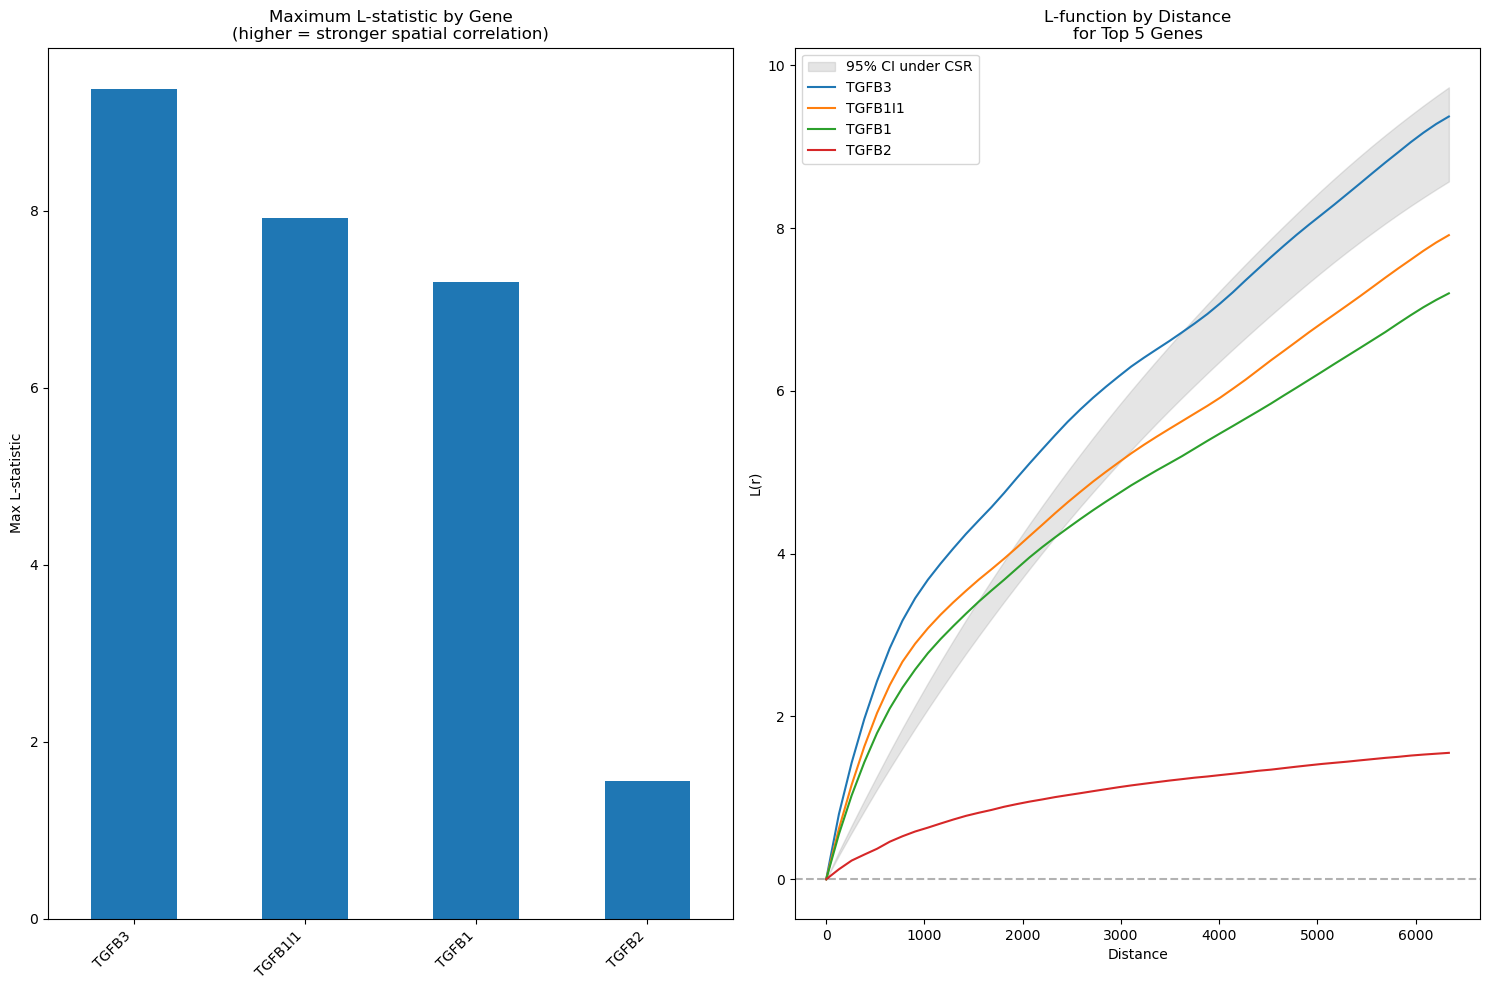

In [41]:
# Get overview of all genes
summary_df = plot_ripley_results(results)
print("Top spatially correlated genes:")
print(summary_df.head(10))

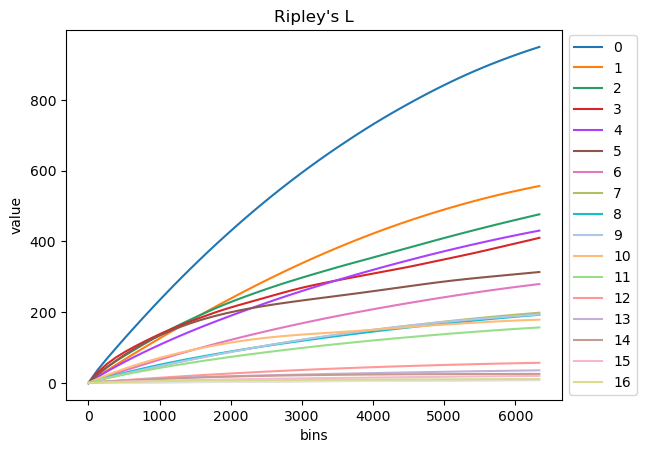

In [29]:
sq.gr.ripley(
    sdatas['ibd'].tables["subsample"],
    cluster_key = "leiden",
    mode = "L"
)

sq.pl.ripley(sdatas['ibd'].tables["subsample"], cluster_key="leiden", mode="L")